# Pseudopotentials

In this example, we'll look at how to use various pseudopotential (PSP)
formats in DFTK and discuss briefly the utility and importance of
pseudopotentials.

Currently, DFTK supports norm-conserving (NC) PSPs in
separable (Kleinman-Bylander) form. Two file formats can currently
be read and used: analytical Hartwigsen-Goedecker-Hutter (HGH) PSPs
and numeric Unified Pseudopotential Format (UPF) PSPs.

In brief, the pseudopotential approach replaces the all-electron
atomic potential with an effective atomic potential. In this pseudopotential,
tightly-bound core electrons are completely eliminated ("frozen") and
chemically-active valence electron wavefunctions are replaced with
smooth pseudo-wavefunctions whose Fourier representations decay quickly.
Both these transformations aim at reducing the number of Fourier modes required
to accurately represent the wavefunction of the system, greatly increasing
computational efficiency.

Different PSP generation codes produce various file formats which contain the
same general quantities required for pesudopotential evaluation. HGH PSPs
are constructed from a fixed functional form based on Gaussians, and the files
simply tablulate various coefficients fitted for a given element. UPF PSPs
take a more flexible approach where the functional form used to generate the
PSP is arbitrary, and the resulting functions are tabulated on a radial grid
in the file. The UPF file format is documented here:
http://pseudopotentials.quantum-espresso.org/home/unified-pseudopotential-format.

In this example, we will compare the convergence of an analytical HGH PSP with
a modern UPF PSP from [PseudoDojo](http://www.pseudo-dojo.org/).
Then, we will compare the bandstructure at the converged parameters calculated
using the two PSPs.

In [1]:
using DFTK
using Downloads
using Unitful
using Plots

Here, we will use Perdew-Wang LDA PSP from [PseudoDojo](http://www.pseudo-dojo.org/),
which is available in the JuliaMolSim
[PseudoLibrary](https://github.com/JuliaMolSim/PseudoLibrary).

In [2]:
PSEUDOLIB = "https://raw.githubusercontent.com/JuliaMolSim/PseudoLibrary"
COMMIT    = "56d1774708e1adfff35d30a403004cb98de4224b"
URL_UPF = PSEUDOLIB * "/$COMMIT/pseudos/pd_nc_sr_lda_standard_04_upf/Li.upf";

We load the HGH and UPF PSPs using `load_psp`, which determines the
file format using the file extension.

In [3]:
psp_hgh  = load_psp("hgh/lda/li-q3.hgh");
path_upf = Downloads.download(URL_UPF, joinpath(tempdir(), "Li.upf"))
psp_upf  = load_psp(path_upf);

First, we'll take a look at the energy cutoff convergence of these two pseudopotentials.
For both pseudos, a reference energy is calculated with a cutoff of 140 Hartree, and
SCF calculations are run at increasing cutoffs until 1 meV / atom convergence is reached.

<img src="https://docs.dftk.org/stable/assets/li_pseudos_ecut_convergence.png" width=600 height=400 />

The converged cutoffs are 128 Ha and 36 Ha for the HGH
and UPF pseudos respectively. We see that the HGH pseudopotential
is much *harder*, i.e. it requires a higher energy cutoff, than the UPF PSP. In general,
numeric pseudopotentials tend to be softer than analytical pseudos because of the
flexibility of sampling arbitrary functions on a grid.

Next, to see that the different pseudopotentials give reasonbly similar results,
we'll look at the bandstructures calculated using the HGH and UPF PSPs. Even though
the convered cutoffs are 128 and 36 Ha, we perform these calculations with a cutoff of
24 Ha for both PSPs.

In [4]:
function run_bands(psp)
    a = -1.53877u"Å"
    b = -2.66523u"Å"
    c = -4.92295u"Å"
    lattice = [ a  a  0;
               -b  b  0;
                0  0 -c]
    Li = ElementPsp(:Li; psp)
    atoms     = [Li, Li]
    positions = [[1/3, 2/3, 1/4],
                 [2/3, 1/3, 3/4]]

    # These are (as you saw above) completely unconverged parameters
    model = model_LDA(lattice, atoms, positions; temperature=1e-2)
    basis = PlaneWaveBasis(model; Ecut=24, kgrid=(6, 6, 4))

    scfres   = self_consistent_field(basis; tol=1e-4)
    bandplot = plot_bandstructure(scfres)
    (; scfres, bandplot)
end;

The SCF and bandstructure calculations can then be performed using the two PSPs,
where we notice in particular the difference in total energies.

In [5]:
result_hgh = run_bands(psp_hgh)
result_hgh.scfres.energies

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -13.91966196585                   -0.12    5.2         
  2   -13.98176496231       -1.21       -0.71    1.9    989ms
  3   -13.98666637633       -2.31       -1.52    2.6    1.10s
  4   -13.98668184761       -4.81       -2.21    1.0    780ms
  5   -13.98668226500       -6.38       -2.95    2.4    964ms
  6   -13.98668236027       -7.02       -3.99    2.6    961ms
  7   -13.98668236469       -8.35       -4.34    3.6    1.22s
Computing bands along kpath:
       Γ -> M -> K -> Γ -> A -> L -> H -> A  and  L -> M  and  H -> K
Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:27


Energy breakdown (in Ha):
    Kinetic             11.3792232
    AtomicLocal         -20.7901902
    AtomicNonlocal      0.0000000 
    Ewald               -5.0511706
    PspCorrection       -0.0009254
    Hartree             3.7115898 
    Xc                  -3.2266855
    Entropy             -0.0085236

    total               -13.986682364686

In [6]:
result_upf = run_bands(psp_upf)
result_upf.scfres.energies

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -14.14866241482                   -0.15    5.1         
  2   -14.21786701911       -1.16       -0.76    2.0    1.13s
  3   -14.22231378232       -2.35       -1.54    2.6    1.18s
  4   -14.22233966752       -4.59       -2.63    1.0    806ms
  5   -14.22234159962       -5.71       -2.98    3.0    1.13s
  6   -14.22234164498       -7.34       -4.08    1.5    825ms
Computing bands along kpath:
       Γ -> M -> K -> Γ -> A -> L -> H -> A  and  L -> M  and  H -> K
Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:27


Energy breakdown (in Ha):
    Kinetic             10.2239403
    AtomicLocal         -10.9142054
    AtomicNonlocal      -8.9743168
    Ewald               -5.0511706
    PspCorrection       0.1151544 
    Hartree             3.5205946 
    Xc                  -3.1341549
    Entropy             -0.0081831

    total               -14.222341644982

But while total energies are not physical and thus allowed to differ,
the bands (as an example for a physical quantity) are very similar for both pseudos:

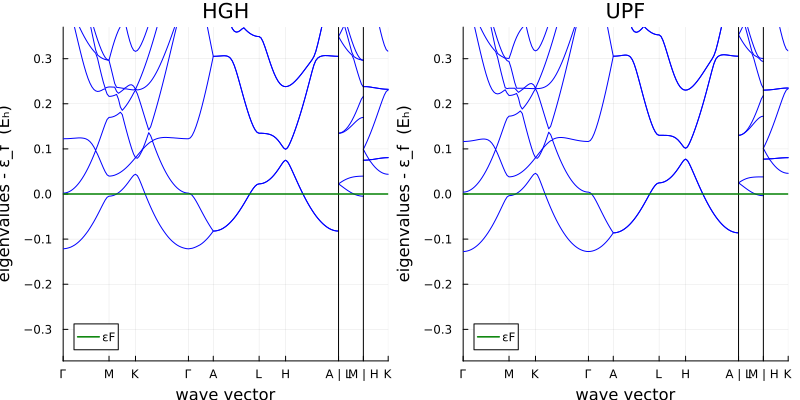

In [7]:
plot(result_hgh.bandplot, result_upf.bandplot, titles=["HGH" "UPF"], size=(800, 400))